---
---

# ***Code Starts Here***

---
---

# ***Loading Images***

## **API file**

In [ ]:
###### Load Kaggle Authentication File ######
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abobakrhusseinsh","key":"3ff4770cc1b39d1a54c232e36bfc1277"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 98% 1.12G/1.14G [00:08<00:00, 143MB/s]
100% 1.14G/1.14G [00:08<00:00, 141MB/s]


## **Extract Images**

In [ ]:
import zipfile
file_name = "covid19-radiography-database.zip"
with zipfile.ZipFile(file_name,'r') as zipm:
  zipm.extractall()
  print('Done')

Done


# ***Imports***

In [ ]:
############################
##        Imports         ##
############################
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import shutil
import matplotlib.pyplot as plt

from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.optimizers import SGD

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import time
import sys
from tensorflow.keras.losses import categorical_crossentropy

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from keras import models
from keras import layers
from keras import optimizers

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions
from keras.applications.resnet50 import ResNet50

from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import decode_predictions

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3  import preprocess_input
from tensorflow.keras.applications.inception_v3  import decode_predictions

# ***Pathes***

In [ ]:
Path_COVID = '/content/COVID-19 Radiography Database/COVID/COVID'
Path_Normal = '/content/COVID-19 Radiography Database/NORMAL/NORMAL'
Path_Viral = '/content/COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia'

# ***Initialization & Images Reading***

In [ ]:
Normal = []                                                                     # Normal Data Array
COVID = []                                                                      # COVID Data Array
Viral = []                                                                      # Viral Data Array

# Loop TO Append Data In COVID Array
for i in range(1,1201):
  Img = Image.open(Path_COVID+' (' + str(i) + ')' + '.png').resize((256,256)).convert('RGB')
  COVID.append(np.array(Img))

# Loop TO Append Data In Noraml Array
for i in range(1,1342):
  Img = Image.open(Path_Normal+' (' + str(i) + ')' + '.png').resize((256,256)).convert('RGB')
  Normal.append(np.array(Img))

# Loop TO Append Data In Viral Array
for i in range(1,1346):
  Img = Image.open(Path_Viral+' (' + str(i) + ')' + '.png').resize((256,256)).convert('RGB')
  Viral.append(np.array(Img))

COVID = np.array(COVID)
Normal = np.array(Normal)
Viral = np.array(Viral)

print("Done")


Done


In [ ]:
print(COVID.shape)
print(Normal.shape)
print(Viral.shape)

(1200, 256, 256, 3)
(1341, 256, 256, 3)
(1345, 256, 256, 3)


In [ ]:
Augmentation_flag=0

# ***Augmentation***

In [ ]:
Augmentation_flag=1
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"), 
  layers.experimental.preprocessing.RandomRotation(0.35),
  # layers.experimental.SyncBatchNormalization([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
]) 

## **Covid Augmentation**

In [ ]:
augmented_images=[]                                                             # COVID Augmented Images Array

for image in COVID :
  #increate dims becease data_agu accetps 4D
  image = tf.expand_dims(tf.constant(image), 0)                               
  augmented_image= data_augmentation(image)                                   # Call Augmentation Class
  augmented_image=np.array(augmented_image).reshape((256, 256, 3))
  augmented_images.append(augmented_image)

# Concatenate Merge With No Error in Shape
COVID=np.concatenate((COVID,np.array(augmented_images)))                        

In [ ]:
COVID.shape

(2400, 256, 256, 3)

## **Normal Augmentation**

In [ ]:
augmented_images=[]                                                             # Noraml Augmented Images Array

for image in Normal :
  #increate dims becease data_agu accetps 4D
  image = tf.expand_dims(tf.constant(image), 0)    
  augmented_image= data_augmentation( image )                                   # Call Augmentation Class
  augmented_image=np.array(augmented_image).reshape((256, 256, 3))
  augmented_images.append(augmented_image)

# Concatenate Merge With No Error in Shape
Normal=np.concatenate((Normal,np.array(augmented_images))) 

In [ ]:
print(COVID.shape)
print(Normal.shape)
print(Viral.shape)

(2400, 256, 256, 3)
(2682, 256, 256, 3)
(1345, 256, 256, 3)


## **Viral Augmentation**

In [ ]:
augmented_images=[]                                                             # Viral Augmented Images Array

for image in Viral :
  #increate dims becease data_agu accetps 4D
  image = tf.expand_dims(tf.constant(image), 0)  
  augmented_image= data_augmentation( image )                                   # Call Augmentation Class
  augmented_image=np.array(augmented_image).reshape((256, 256, 3))
  augmented_images.append(augmented_image)

# Concatenate Merge With No Error in Shape
Viral=np.concatenate((Viral,np.array(augmented_images))) 

In [ ]:
Viral.shape

(2690, 256, 256, 3)

In [ ]:
print(COVID.shape)
print(Normal.shape)
print(Viral.shape)

(1200, 256, 256, 3)
(1341, 256, 256, 3)
(1345, 256, 256, 3)


# ***Constructing Labels & Dataset Arrays***

Warning!!! run this cell if aumgmentation is true : run next cell ,else : skip

In [ ]:
Dataset = np.concatenate((COVID[0:2399],Normal[0:2399],Viral[0:2399]))

In [ ]:
Dataset = np.concatenate((COVID,Normal,Viral))

In [ ]:
Dataset=[]

In [ ]:
Dataset.shape

(3886, 256, 256, 3)

Warning!!! run this cell if aumgmentation is true : run next cell ,else : skip

In [ ]:
##############################
##       ############       ##
##       ## Labels ##       ##
##       ############       ##
##    COVID_Label  =>  1    ##
##    NORMAL_Label =>  0    ##
##    VIRAL_Label  => -1    ##   
##############################

Covidlabel = np.full((len(COVID[0:2399]),1), 1)
Normallabel=np.full((len(Normal[0:2399]),1), 0)
Virallabel=np.full((len(Viral[0:2399]),1),-1)

Y = np.concatenate((Covidlabel,Normallabel,Virallabel))                         # Y is Array of Labels


In [ ]:
##############################
##       ############       ##
##       ## Labels ##       ##
##       ############       ##
##    COVID_Label  =>  1    ##
##    NORMAL_Label =>  0    ##
##    VIRAL_Label  => -1    ##   
##############################

Covidlabel = np.full((len(COVID),1), 1)
Normallabel=np.full((len(Normal),1), 0)
Virallabel=np.full((len(Viral),1),-1)
Y = np.concatenate((Covidlabel,Normallabel,Virallabel)) 

In [ ]:
print(Y.shape)
print(Dataset.shape)

(3886, 1)
(3886, 256, 256, 3)


# ***Splitting and Categorization***

## **Spilt** 

In [ ]:
#################################
##      Splitting Dataset      ##
#################################
x_train, x_test, y_train, y_test = train_test_split(Dataset,Y , test_size=0.3,random_state=40, stratify=Y)
x_train, x_val, y_train, y_val= train_test_split(x_train,y_train, test_size=0.2, random_state=1,stratify=y_train)

# Convert To Numpy Array
trainX= np.array(x_train)
testX = np.array(x_test)
trainY= np.array(y_train)
testY = np.array(y_test)
valX=np.array(x_val)
valY=np.array(y_val)

## **Categorization (Labels' Encodeing )**

In [ ]:
trainY = to_categorical(trainY, 3)                                              # Categorize Labels Training Array 
testY = to_categorical(testY, 3)                                                # Categorize Labels Testing Array 
valY=to_categorical(valY, 3) 

## **Normalization** 

In [ ]:
trainX = trainX.astype("float32")/ 255.0                                       # Normalize Labels Training Array 
testX = testX.astype("float32") / 255.0                                         # Normalize Labels Testing Array 
valX = valX.astype("float32") / 255.0 

In [ ]:
print(trainX.shape)
print(testX.shape)
print(valX.shape)

(2176, 256, 256, 3)
(1166, 256, 256, 3)
(544, 256, 256, 3)


# ***Training loop***

## **HyperParameters** 

In [ ]:
EPOCHS =  10                                                                    # Epochs
BS = 64                                                                         # Batch Size
INIT_LR = 1e-3                                                                  # Learning Rate

## **Step Function**

In [ ]:
def step(model,x, y,optimizer):
# keep track of our gradients
  with tf.GradientTape() as tape:
    # make a prediction using the model and then calculate the loss
    pred = model(x)
    loss = categorical_crossentropy(y, pred)
    
  # calculate the gradients using our tape and then update the model weights
  grads = tape.gradient(loss,model.trainable_variables)
  optimizer.apply_gradients(zip(grads,model.trainable_variables))
  
  return loss  

## **Main Training Function**

In [ ]:
def trainingloop(model,trainX,trainY,numbrofbatches,EPOCHS,optimizer) :
  numUpdates = int(trainX.shape[0] / numbrofbatches) #1
  history_validation_accuracy=[]
  history_training_accuracy=[]


  # loop over the number of epochs
  for epoch in range(0, EPOCHS):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = []

    # show the current epoch number
    print("[INFO] starting epoch {}/{}...".format( epoch + 1, EPOCHS), end="")
    sys.stdout.flush()
    epochStart = time.time()
    model.predict(testX)

    # loop over the data in batch size increments
    for i in range(0, numUpdates):
      # determine starting and ending slice indexes for the current batch
      start = i * numbrofbatches
      end = start + numbrofbatches

      # take a step
      loss=step(model,trainX[start:end], trainY[start:end],optimizer)#5
      epoch_loss_avg.update_state(loss)
      y_pred=model.predict(trainX[start:end])

      y_pred = np.argmax(y_pred, axis=1)
      y_true=np.argmax(trainY[start:end], axis=1)
      epoch_accuracy.append(accuracy_score(y_true, y_pred)) 
      
    
    averarge_train_acc=np.mean(np.array(epoch_accuracy))
    history_training_accuracy.append(averarge_train_acc)
    
    
    print("Epoch {:03d}: Loss: {:.3f}, accuracy {}".format(epoch, epoch_loss_avg.result(),averarge_train_acc))
    
    history_validation_accuracy.append(accuracyvalidation(model,valX,valY))
    epochEnd = time.time()
    del epoch_accuracy
    elapsed = (epochEnd - epochStart) / 60.0
    print("took {:.4} minutes".format(elapsed))
  return history_validation_accuracy,history_training_accuracy


# ***Testing***

In [ ]:
def testing (modelx,testX,testY):        
  (loss, acc) =  modelx.evaluate(testX, testY)
  print("[INFO] test accuracy: {:.4f}".format(acc))

## **Reporting Model Performance**

In [ ]:
def report_yourmoder(model,testX,testY) : 
  y_pred=model.predict(testX)
  y_pred = np.argmax(y_pred, axis=1)
  Ytrue=np.argmax(testY, axis=1)
  Conmat=confusion_matrix(Ytrue, y_pred)

  print("===================================")
  print("confunsion matrix is \n {} {} {} \n {} {} {} \n {} {} {} ".format(Conmat[0][0],Conmat[0][1],Conmat[0][2],Conmat[1][0],Conmat[1][1],Conmat[1][2],Conmat[2][0],Conmat[2][1],Conmat[2][2]))
  print("===================================")

  precision=precision_score(Ytrue, y_pred, average=None)
  print("===================================")
  print("precision is \nclass0:{:.2f} % \nclass1:{:.2f} % \nclass2:{:.2f} % \n".format(precision[0]*100,precision[1]*100,precision[2]*100))
  print("===================================")
  recall=recall_score(Ytrue, y_pred, average=None)

  print("===================================")
  print("recall is \nclass0:{:.2f} % \nclass1:{:.2f} % \nclass2:{:.2f} % \n".format(recall[0]*100,recall[1]*100,recall[2]*100))
  print("===================================")
  f1=f1_score(Ytrue, y_pred, average=None)
  print("===================================")
  print("f1 is \nclass0:{:.2f} % \nclass1:{:.2f} % \nclass2:{:.2f} % \n".format( f1[0]*100, f1[1]*100, f1[2]*100))
  print("===================================")
  
  print("===================================")
  print("accuracy is \nclass0:{:.2f}".format(accuracy_score(Ytrue, y_pred)))
  print("===================================")

In [ ]:
import matplotlib.pyplot as plt

def plotvalidationandTraining(numofepoeh,training,testing) :
  x1 = np.arange(numofepoeh+1)
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  
  training.insert(0,0)
  testing.insert(0,0)

  l1 = ax.plot(x1,training,'y.-') # solid line with yellow colour and square marker
  l2 = ax.plot(x1,testing,'g.-') # dash line with green colour and circle marker
  ax.legend(labels = ('train', 'validation'), loc = 'lower right') # legend placed at lower right
  ax.set_title("comparison between testing and validation accuracy")
  plt.ylim(0, 1)
  plt.ylim(ymin=0) 
  ax.set_xlabel('epoch')
  ax.set_ylabel('accuracy')
  plt.show()
  del training
  del testing

In [ ]:
def accuracyvalidation(model,testX,testY) : 
  y_pred=model.predict(testX)
  y_pred = np.argmax(y_pred, axis=1)
  Ytrue=np.argmax(testY, axis=1)
  accuracy=accuracy_score(Ytrue, y_pred) 

  print("validation accuracy is {:.4f}\n".format( accuracy))
  return accuracy


# ***Basic Models*** 

## **CNN Few Layers Model**

### **Layers**

In [ ]:
cnn_model_fewlayer=  models.Sequential()

cnn_model_fewlayer.add(layers.Conv2D(32, (3, 3), input_shape=(256,256,3)))
cnn_model_fewlayer.add(layers.Activation('relu'))
cnn_model_fewlayer.add(layers.MaxPooling2D(pool_size=(2, 2)))

cnn_model_fewlayer.add(layers.Conv2D(128, (3, 3)))
cnn_model_fewlayer.add(layers.Activation('relu'))
cnn_model_fewlayer.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Fully Connected Layer
cnn_model_fewlayer.add(layers.Flatten())
cnn_model_fewlayer.add(layers.Dense(64))
cnn_model_fewlayer.add(layers.Activation('relu'))

cnn_model_fewlayer.add(layers.Dense(512))
cnn_model_fewlayer.add(layers.Activation('relu'))
cnn_model_fewlayer.add(layers.Dropout(0.3))
cnn_model_fewlayer.add(layers.Dense(3))
cnn_model_fewlayer.add(layers.Activation('softmax'))

for layer in cnn_model_fewlayer.layers:
    layer.trainable = True
cnn_model_fewlayer.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 128)     36992     
_________________________________________________________________
activation_1 (Activation)    (None, 125, 125, 128)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 492032)           

### **With Augmentation**

In [ ]:
epoch=10
optfew = Adam(lr=INIT_LR, decay=INIT_LR / epoch)
cnn_model_fewlayer.compile(optimizer=optfew, loss=categorical_crossentropy, metrics=["acc"])

In [ ]:
history_validation_accuracy,history_training_accuracy=trainingloop(cnn_model_fewlayer,trainX,trainY,128,epoch,optfew)

[INFO] starting epoch 1/10...Epoch 000: Loss: 131.578, accuracy 0.5660282258064516
validation accuracy is 0.7450

took 0.3042 minutes
[INFO] starting epoch 2/10...Epoch 001: Loss: 0.423, accuracy 0.8805443548387096
validation accuracy is 0.8849

took 0.1818 minutes
[INFO] starting epoch 3/10...Epoch 002: Loss: 0.175, accuracy 0.9644657258064516
validation accuracy is 0.8661

took 0.1816 minutes
[INFO] starting epoch 4/10...Epoch 003: Loss: 0.078, accuracy 0.9899193548387096
validation accuracy is 0.8819

took 0.1814 minutes
[INFO] starting epoch 5/10...Epoch 004: Loss: 0.028, accuracy 0.9967237903225806
validation accuracy is 0.8720

took 0.1815 minutes
[INFO] starting epoch 6/10...Epoch 005: Loss: 0.012, accuracy 0.9987399193548387
validation accuracy is 0.8790

took 0.1815 minutes
[INFO] starting epoch 7/10...Epoch 006: Loss: 0.015, accuracy 0.9994959677419355
validation accuracy is 0.9048

took 0.1815 minutes
[INFO] starting epoch 8/10...Epoch 007: Loss: 0.038, accuracy 0.9987399193

#### **Test Acurracy**

In [ ]:
# cnn_model_fewlayer.evaluate(valX,valY)
cnn_model_fewlayer.evaluate(testX,testY)

68/68 [==============================] - 1s 13ms/step - loss: 0.8994 - acc: 0.8575


[0.8357101082801819, 0.8615740537643433]

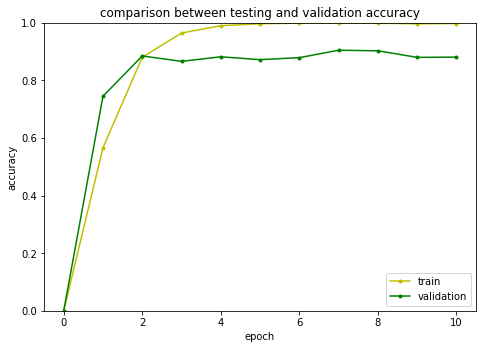

0

In [ ]:
plotvalidationandTraining(10,history_training_accuracy,history_validation_accuracy)
history_validation_accuracy.pop(0)
history_training_accuracy.pop(0)

#### **Report** 

In [ ]:
report_yourmoder(cnn_model_fewlayer,testX,testY) 
del optfew 
del cnn_model_fewlayer
del history_training_accuracy
del history_validation_accuracy
print("done")

confunsion matrix is 
 617 9 94 
 44 602 74 
 59 19 642 
precision is 
class0:85.69 % 
class1:95.56 % 
class2:79.26 % 

recall is 
class0:85.69 % 
class1:83.61 % 
class2:89.17 % 

f1 is 
class0:85.69 % 
class1:89.19 % 
class2:83.92 % 

accuracy is 
class0:0.86
done


### **Without Augmentation**

In [ ]:
epoch=10
optfew = Adam(lr=INIT_LR, decay=INIT_LR / epoch)
cnn_model_fewlayer.compile(optimizer=optfew, loss=categorical_crossentropy, metrics=["acc"])

In [ ]:
history_validation_accuracy,history_training_accuracy=trainingloop(cnn_model_fewlayer,trainX,trainY,128,epoch,optfew)

[INFO] starting epoch 1/10...Epoch 000: Loss: 1.602, accuracy 0.6364889705882353
validation accuracy is 0.8621

took 0.1825 minutes
[INFO] starting epoch 2/10...Epoch 001: Loss: 0.319, accuracy 0.8915441176470589
validation accuracy is 0.9246

took 0.1409 minutes
[INFO] starting epoch 3/10...Epoch 002: Loss: 0.160, accuracy 0.9485294117647058
validation accuracy is 0.9393

took 0.1407 minutes
[INFO] starting epoch 4/10...Epoch 003: Loss: 0.093, accuracy 0.9738051470588235
validation accuracy is 0.9338

took 0.1386 minutes
[INFO] starting epoch 5/10...Epoch 004: Loss: 0.075, accuracy 0.9788602941176471
validation accuracy is 0.9357

took 0.1384 minutes
[INFO] starting epoch 6/10...Epoch 005: Loss: 0.052, accuracy 0.9898897058823529
validation accuracy is 0.9191

took 0.1402 minutes
[INFO] starting epoch 7/10...Epoch 006: Loss: 0.035, accuracy 0.9940257352941176
validation accuracy is 0.9430

took 0.1394 minutes
[INFO] starting epoch 8/10...Epoch 007: Loss: 0.030, accuracy 0.994025735294

#### **Test Acurracy**

In [ ]:
cnn_model_fewlayer.evaluate(testX,testY)

37/37 [==============================] - 1s 19ms/step - loss: 0.2063 - acc: 0.9428


[0.21011513471603394, 0.9408233165740967]

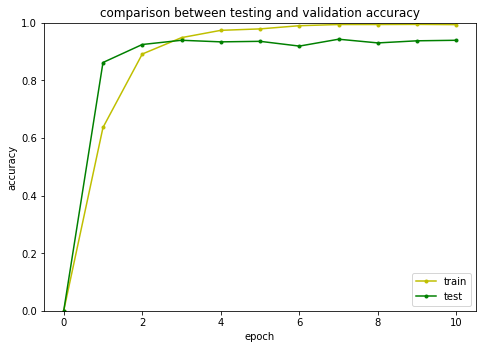

0

In [ ]:
plotvalidationandTraining(10,history_training_accuracy,history_validation_accuracy)
history_validation_accuracy.pop(0)
history_training_accuracy.pop(0)

#### **Report** 

In [ ]:
report_yourmoder(cnn_model_fewlayer,testX,testY) 
del optfew 
del cnn_model_fewlayer
print("done")

confunsion matrix is 
 391 2 9 
 8 349 3 
 36 11 357 
precision is 
class0:89.89 % 
class1:96.41 % 
class2:96.75 % 

recall is 
class0:97.26 % 
class1:96.94 % 
class2:88.37 % 

f1 is 
class0:93.43 % 
class1:96.68 % 
class2:92.37 % 

accuracy is 
class0:0.94
done


## **CNN Many Layers Model**

### **Layers**

In [ ]:
cnn_model_manylayer=  models.Sequential()

cnn_model_manylayer.add(layers.Conv2D(32, (3, 3), input_shape=(256,256,3)))
cnn_model_manylayer.add(layers.Activation('relu'))
cnn_model_manylayer.add(layers.MaxPooling2D(pool_size=(2, 2)))

cnn_model_manylayer.add(layers.Conv2D(64, (3, 3)))
cnn_model_manylayer.add(layers.Activation('relu'))
cnn_model_manylayer.add(layers.MaxPooling2D(pool_size=(2, 2)))
 

cnn_model_manylayer.add(layers.Conv2D(256, (3, 3)))
cnn_model_manylayer.add(layers.Activation('relu'))
cnn_model_manylayer.add(layers.MaxPooling2D(pool_size=(2, 2)))

cnn_model_manylayer.add(layers.Conv2D(512, (3, 3)))
cnn_model_manylayer.add(layers.Activation('relu'))
cnn_model_manylayer.add(layers.MaxPooling2D(pool_size=(2, 2)))

cnn_model_manylayer.add(layers.Conv2D(700, (3, 3)))
cnn_model_manylayer.add(layers.Activation('relu'))
cnn_model_manylayer.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Fully Connected Layer
cnn_model_manylayer.add(layers.Flatten())
cnn_model_manylayer.add(layers.Dense(256))
cnn_model_manylayer.add(layers.Activation('relu'))

cnn_model_manylayer.add(layers.Dense(1024))
cnn_model_manylayer.add(layers.Activation('relu'))
cnn_model_manylayer.add(layers.Dropout(0.3))
cnn_model_manylayer.add(layers.Dense(3))
cnn_model_manylayer.add(layers.Activation('softmax'))

cnn_model_manylayer.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 125, 125, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 256)      

### **With Augmentation**

In [ ]:
epoch=10
optmany = Adam(lr=INIT_LR, decay=INIT_LR / epoch)
cnn_model_manylayer.compile(optimizer=optmany, loss=categorical_crossentropy, metrics=["acc"])

In [ ]:
history_validation_accuracy,history_training_accuracy=trainingloop(cnn_model_manylayer,trainX,trainY,BS,10,optmany)

#### **Test Accuracy**

In [ ]:
testing(cnn_model_manylayer,testX,testY)

68/68 [==============================] - 2s 21ms/step - loss: 0.3850 - acc: 0.8980
[INFO] test accuracy: 0.9014


#### **Report**

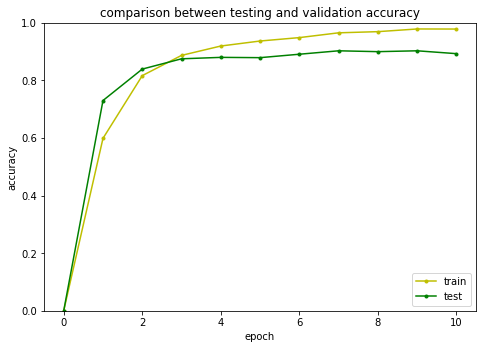

0

In [ ]:
plotvalidationandTraining(10,history_training_accuracy,history_validation_accuracy)
history_validation_accuracy.pop(0)
history_training_accuracy.pop(0)

In [ ]:
report_yourmoder(cnn_model_manylayer,testX,testY) 
del optmany 
del cnn_model_manylayer
print("done")

confunsion matrix is 
 587 67 66 
 3 704 13 
 34 62 624 
precision is 
class0:94.07 % 
class1:84.51 % 
class2:88.76 % 

recall is 
class0:81.53 % 
class1:97.78 % 
class2:86.67 % 

f1 is 
class0:87.35 % 
class1:90.66 % 
class2:87.70 % 

accuracy is 
class0:0.89
done


### **Without Augmentation**

In [ ]:
epoch=10
optmany = Adam(lr=INIT_LR, decay=INIT_LR / epoch)
cnn_model_manylayer.compile(optimizer=optmany, loss=categorical_crossentropy, metrics=["acc"])

In [ ]:
history_validation_accuracy,history_training_accuracy=trainingloop(cnn_model_manylayer,trainX,trainY,BS,epoch,optmany  )

[INFO] starting epoch 1/10...Epoch 000: Loss: 0.800, accuracy 0.6355698529411765
validation accuracy is 0.8364

took 0.1761 minutes
[INFO] starting epoch 2/10...Epoch 001: Loss: 0.311, accuracy 0.9021139705882353
validation accuracy is 0.9118

took 0.1708 minutes
[INFO] starting epoch 3/10...Epoch 002: Loss: 0.161, accuracy 0.9563419117647058
validation accuracy is 0.9246

took 0.171 minutes
[INFO] starting epoch 4/10...Epoch 003: Loss: 0.109, accuracy 0.9742647058823529
validation accuracy is 0.9412

took 0.1718 minutes
[INFO] starting epoch 5/10...Epoch 004: Loss: 0.103, accuracy 0.9724264705882353
validation accuracy is 0.9393

took 0.1715 minutes
[INFO] starting epoch 6/10...Epoch 005: Loss: 0.078, accuracy 0.9820772058823529
validation accuracy is 0.9449

took 0.1708 minutes
[INFO] starting epoch 7/10...Epoch 006: Loss: 0.093, accuracy 0.9774816176470589
validation accuracy is 0.9375

took 0.1712 minutes
[INFO] starting epoch 8/10...Epoch 007: Loss: 0.066, accuracy 0.9898897058823

#### **Test Acurracy**

In [ ]:
testing(cnn_model_manylayer,testX,testY)

37/37 [==============================] - 1s 21ms/step - loss: 0.2039 - acc: 0.9333
[INFO] test accuracy: 0.9322


#### **Report** 

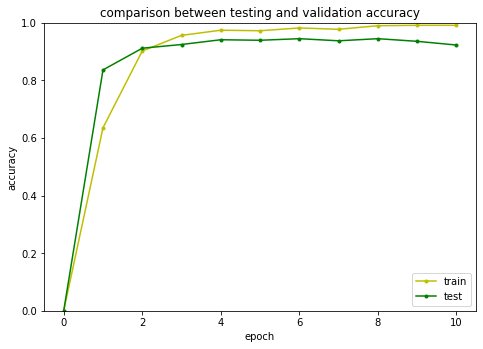

0

In [ ]:
plotvalidationandTraining(10,history_training_accuracy,history_validation_accuracy)
history_validation_accuracy.pop(0)
history_training_accuracy.pop(0)

In [ ]:
report_yourmoder(cnn_model_manylayer,testX,testY) 
del optmany 
del cnn_model_manylayer
print("done")

confunsion matrix is 
 383 0 19 
 11 318 31 
 16 2 386 
precision is 
class0:93.41 % 
class1:99.38 % 
class2:88.53 % 

recall is 
class0:95.27 % 
class1:88.33 % 
class2:95.54 % 

f1 is 
class0:94.33 % 
class1:93.53 % 
class2:91.90 % 

accuracy is 
class0:0.93
done


## **FCN Many Layers Model**


### **Layers**

In [ ]:
inputs = tf.keras.Input(shape=(256,256,3))

many_layer_model= layers.Flatten()(inputs)
# Add a fully connected layer with 512 hidden units and ReLU activation
many_layer_model = layers.Dense(1200, activation='relu')(many_layer_model)
many_layer_model = layers.Dropout(0.5)(many_layer_model )

many_layer_model = layers.Dense(1000, activation='relu')(many_layer_model)
many_layer_model = layers.Dropout(0.5)(many_layer_model )
many_layer_model = layers.Dense(900, activation='relu')(many_layer_model)
many_layer_model = layers.Dropout(0.5)(many_layer_model )
many_layer_model = layers.Dense(800, activation='relu')(many_layer_model)
many_layer_model = layers.Dropout(0.5)(many_layer_model )

many_layer_model = layers.Dense(256, activation='relu')(many_layer_model)
many_layer_model = layers.Dropout(0.5)(many_layer_model )
many_layer_model = layers.Dense(128, activation='relu')(many_layer_model)
many_layer_model = layers.Dropout(0.5)(many_layer_model )
many_layer_model = layers.Dense(64, activation='relu')(many_layer_model)

# many_layer_model = layers.Dropout(0.5)(many_layer_model )
many_layer_model = layers.Dense(32, activation='relu')(many_layer_model)
# many_layer_model = layers.Dropout(0.5)(many_layer_model )

many_layer_model = layers.Dense(16, activation='relu')(many_layer_model)
# many_layer_model = layers.Dropout(0.5)(many_layer_model )

# Add a final sigmoid layer for classification
many_layer_model = layers.Dense(3, activation='softmax')(many_layer_model )
many_layer_model = Model(inputs=inputs, outputs=many_layer_model)


### **With Augmentation**

In [ ]:
epoch=10
optmany =Adam(lr=INIT_LR, decay=INIT_LR / epoch)
many_layer_model.compile(optimizer=optmany, loss=categorical_crossentropy, metrics=["acc"])

In [ ]:
many_layer_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 196608)            0         
_________________________________________________________________
dense (Dense)                (None, 1200)              235930800 
_________________________________________________________________
dropout (Dropout)            (None, 1200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1201000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 900)               900900

In [ ]:
history_validation_accuracy,history_training_accuracy=trainingloop(many_layer_model,trainX,trainY,BS,10,optmany)

[INFO] starting epoch 1/10...Epoch 000: Loss: 6.308, accuracy 0.43170362903225806
validation accuracy is 0.6319

took 0.1495 minutes
[INFO] starting epoch 2/10...Epoch 001: Loss: 0.754, accuracy 0.6428931451612904
validation accuracy is 0.7083

took 0.1212 minutes
[INFO] starting epoch 3/10...Epoch 002: Loss: 0.619, accuracy 0.7424395161290323
validation accuracy is 0.7758

took 0.121 minutes
[INFO] starting epoch 4/10...Epoch 003: Loss: 0.560, accuracy 0.7799899193548387
validation accuracy is 0.8433

took 0.1211 minutes
[INFO] starting epoch 5/10...Epoch 004: Loss: 0.520, accuracy 0.8009072580645161
validation accuracy is 0.8254

took 0.1212 minutes
[INFO] starting epoch 6/10...Epoch 005: Loss: 0.430, accuracy 0.8359375
validation accuracy is 0.8492

took 0.1212 minutes
[INFO] starting epoch 7/10...Epoch 006: Loss: 0.407, accuracy 0.850554435483871
validation accuracy is 0.8462

took 0.1214 minutes
[INFO] starting epoch 8/10...Epoch 007: Loss: 0.375, accuracy 0.8621471774193549
valid

#### **Test Acurracy**

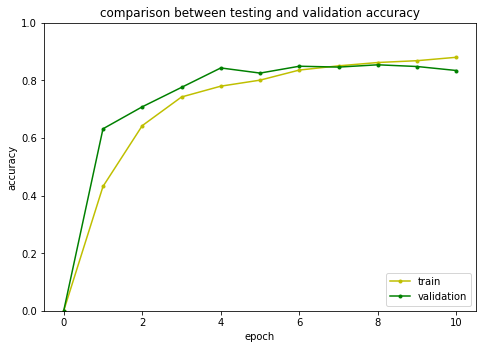

0

In [ ]:
plotvalidationandTraining(10,history_training_accuracy,history_validation_accuracy)
history_validation_accuracy.pop(0)
history_training_accuracy.pop(0)

In [ ]:
testing(many_layer_model,testX,testY)

68/68 [==============================] - 1s 16ms/step - loss: 0.4197 - acc: 0.8415
[INFO] test accuracy: 0.8426


#### **Report**

In [ ]:
report_yourmoder(many_layer_model,testX,testY) 
del inputs
del optmany
del many_layer_model

confunsion matrix is 
 577 53 90 
 6 704 10 
 104 77 539 
precision is 
class0:83.99 % 
class1:84.41 % 
class2:84.35 % 

recall is 
class0:80.14 % 
class1:97.78 % 
class2:74.86 % 

f1 is 
class0:82.02 % 
class1:90.60 % 
class2:79.32 % 

accuracy is 
class0:0.84


In [ ]:
inputs = tf.keras.Input(shape=(256,256,3))

many_layer_model= layers.Flatten()(inputs)
# Add a fully connected layer with 512 hidden units and ReLU activation
many_layer_model = layers.Dense(1200, activation='relu')(many_layer_model)
many_layer_model = layers.Dropout(0.5)(many_layer_model )

many_layer_model = layers.Dense(1000, activation='relu')(many_layer_model)
many_layer_model = layers.Dropout(0.5)(many_layer_model )
many_layer_model = layers.Dense(900, activation='relu')(many_layer_model)
many_layer_model = layers.Dropout(0.5)(many_layer_model )
many_layer_model = layers.Dense(800, activation='relu')(many_layer_model)
many_layer_model = layers.Dropout(0.5)(many_layer_model )

many_layer_model = layers.Dense(256, activation='relu')(many_layer_model)
many_layer_model = layers.Dropout(0.5)(many_layer_model )
many_layer_model = layers.Dense(128, activation='relu')(many_layer_model)
many_layer_model = layers.Dropout(0.5)(many_layer_model )
many_layer_model = layers.Dense(64, activation='relu')(many_layer_model)

# many_layer_model = layers.Dropout(0.5)(many_layer_model )
many_layer_model = layers.Dense(32, activation='relu')(many_layer_model)
# many_layer_model = layers.Dropout(0.5)(many_layer_model )

many_layer_model = layers.Dense(16, activation='relu')(many_layer_model)
# many_layer_model = layers.Dropout(0.5)(many_layer_model )

# Add a final sigmoid layer for classification
many_layer_model = layers.Dense(3, activation='softmax')(many_layer_model )
many_layer_model = Model(inputs=inputs, outputs=many_layer_model)


### **Without Augmentation** 

In [ ]:
epoch=15
optmany =Adam(lr=INIT_LR, decay=INIT_LR / epoch)
many_layer_model.compile(optimizer=optmany, loss=categorical_crossentropy, metrics=["acc"])

In [ ]:
history_validation_accuracy,history_training_accuracy=trainingloop(many_layer_model,trainX,trainY,BS,15,optmany)

[INFO] starting epoch 1/15...Epoch 000: Loss: 3164.358, accuracy 0.34237132352941174
validation accuracy is 0.5754

took 0.05447 minutes
[INFO] starting epoch 2/15...Epoch 001: Loss: 153.493, accuracy 0.5330882352941176
validation accuracy is 0.6342

took 0.0521 minutes
[INFO] starting epoch 3/15...Epoch 002: Loss: 5.723, accuracy 0.7141544117647058
validation accuracy is 0.7482

took 0.0521 minutes
[INFO] starting epoch 4/15...Epoch 003: Loss: 2.178, accuracy 0.8207720588235294
validation accuracy is 0.8585

took 0.05219 minutes
[INFO] starting epoch 5/15...Epoch 004: Loss: 0.855, accuracy 0.8556985294117647
validation accuracy is 0.8897

took 0.05206 minutes
[INFO] starting epoch 6/15...Epoch 005: Loss: 0.813, accuracy 0.8451286764705882
validation accuracy is 0.8254

took 0.05234 minutes
[INFO] starting epoch 7/15...Epoch 006: Loss: 1.270, accuracy 0.8432904411764706
validation accuracy is 0.8824

took 0.0518 minutes
[INFO] starting epoch 8/15...Epoch 007: Loss: 0.834, accuracy 0.87

#### **Test Acurracy**

In [ ]:
testing(many_layer_model,testX,testY)

37/37 [==============================] - 1s 11ms/step - loss: 0.7163 - acc: 0.8878
[INFO] test accuracy: 0.8851


#### **Report**

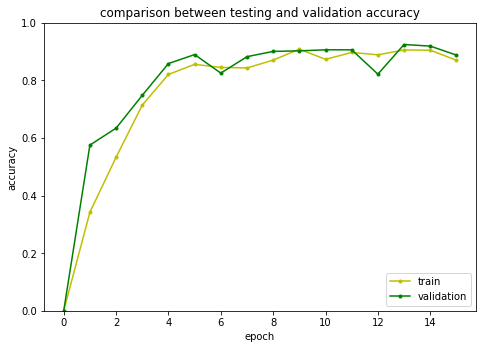

confunsion matrix is 
 331 3 68 
 4 315 41 
 15 3 386 
precision is 
class0:94.57 % 
class1:98.13 % 
class2:77.98 % 

recall is 
class0:82.34 % 
class1:87.50 % 
class2:95.54 % 

f1 is 
class0:88.03 % 
class1:92.51 % 
class2:85.87 % 

accuracy is 
class0:0.89


In [ ]:
plotvalidationandTraining(15,history_training_accuracy,history_validation_accuracy)
history_validation_accuracy.pop(0)
history_training_accuracy.pop(0)
report_yourmoder(many_layer_model,testX,testY) 
del inputs
del optmany
del many_layer_model

## **FCN Few Layers Model**

In [ ]:
del few_layer_model

### **Layers**

In [ ]:
few_layer_model = models.Sequential()

few_layer_model.add(layers.Flatten(input_shape=(256,256,3)))
few_layer_model.add(layers.Dense(1024, activation='relu', input_dim=(256*256*3)))
few_layer_model.add(layers.Dense(50, activation='relu'))
few_layer_model.add(layers.Dense(3, activation='softmax'))

few_layer_model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              201327616 
_________________________________________________________________
dense_28 (Dense)             (None, 50)                51250     
_________________________________________________________________
dense_29 (Dense)             (None, 3)                 153       
Total params: 201,379,019
Trainable params: 201,379,019
Non-trainable params: 0
_________________________________________________________________


### **With Augmentation**

In [ ]:
epoch=20
opx=Adam(lr=INIT_LR, decay=INIT_LR / epoch)
few_layer_model.compile(optimizer=opx, loss=categorical_crossentropy, metrics=["acc"])

In [ ]:
history_validation_accuracy,history_training_accuracy=trainingloop(few_layer_model,trainX,trainY,BS,10,opx)

[INFO] starting epoch 1/10...Epoch 000: Loss: 40.892, accuracy 0.5173891129032258
validation accuracy is 0.6786

took 0.1165 minutes
[INFO] starting epoch 2/10...Epoch 001: Loss: 2.144, accuracy 0.6663306451612904
validation accuracy is 0.5387

took 0.1147 minutes
[INFO] starting epoch 3/10...Epoch 002: Loss: 1.924, accuracy 0.7013608870967742
validation accuracy is 0.5853

took 0.1155 minutes
[INFO] starting epoch 4/10...Epoch 003: Loss: 1.532, accuracy 0.7167338709677419
validation accuracy is 0.5784

took 0.1156 minutes
[INFO] starting epoch 5/10...Epoch 004: Loss: 1.745, accuracy 0.7207661290322581
validation accuracy is 0.6577

took 0.1154 minutes
[INFO] starting epoch 6/10...Epoch 005: Loss: 1.660, accuracy 0.7260584677419355
validation accuracy is 0.8085

took 0.1152 minutes
[INFO] starting epoch 7/10...Epoch 006: Loss: 2.328, accuracy 0.7222782258064516
validation accuracy is 0.8185

took 0.115 minutes
[INFO] starting epoch 8/10...Epoch 007: Loss: 1.747, accuracy 0.762348790322

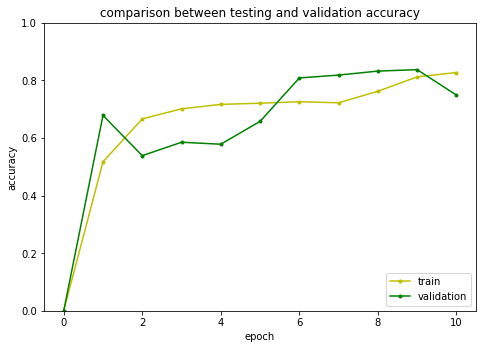

0

In [ ]:
plotvalidationandTraining(10,history_training_accuracy,history_validation_accuracy)
history_validation_accuracy.pop(0)
history_training_accuracy.pop(0)

#### **Test Accuracy**

In [ ]:
testing(few_layer_model,testX,testY)

68/68 [==============================] - 1s 15ms/step - loss: 1.0535 - acc: 0.7766
[INFO] test accuracy: 0.7699


#### **Report**

In [ ]:
report_yourmoder(few_layer_model,testX,testY) 
del opx
del few_layer_model
print("done")

confunsion matrix is 
 639 76 5 
 25 690 5 
 230 156 334 
precision is 
class0:71.48 % 
class1:74.84 % 
class2:97.09 % 

recall is 
class0:88.75 % 
class1:95.83 % 
class2:46.39 % 

f1 is 
class0:79.18 % 
class1:84.04 % 
class2:62.78 % 

accuracy is 
class0:0.77
done


### **Without Augmentation**

In [ ]:
epoch=10
opx=Adam(lr=INIT_LR, decay=INIT_LR / epoch)
few_layer_model.compile(optimizer=opx, loss=categorical_crossentropy, metrics=["acc"])

In [ ]:
history_validation_accuracy,history_training_accuracy=trainingloop(few_layer_model,trainX,trainY,BS,10,opx)

[INFO] starting epoch 1/10...Epoch 000: Loss: 38.674, accuracy 0.6070772058823529
validation accuracy is 0.7518

took 0.06534 minutes
[INFO] starting epoch 2/10...Epoch 001: Loss: 2.766, accuracy 0.8713235294117647
validation accuracy is 0.9007

took 0.06391 minutes
[INFO] starting epoch 3/10...Epoch 002: Loss: 1.600, accuracy 0.8993566176470589
validation accuracy is 0.8842

took 0.06456 minutes
[INFO] starting epoch 4/10...Epoch 003: Loss: 2.248, accuracy 0.8249080882352942
validation accuracy is 0.7794

took 0.06424 minutes
[INFO] starting epoch 5/10...Epoch 004: Loss: 3.763, accuracy 0.8676470588235294
validation accuracy is 0.8750

took 0.06414 minutes
[INFO] starting epoch 6/10...Epoch 005: Loss: 2.860, accuracy 0.8511029411764706
validation accuracy is 0.9283

took 0.06403 minutes
[INFO] starting epoch 7/10...Epoch 006: Loss: 1.602, accuracy 0.8828125
validation accuracy is 0.9044

took 0.0641 minutes
[INFO] starting epoch 8/10...Epoch 007: Loss: 1.517, accuracy 0.90119485294117

#### **Test Accuracy**

In [ ]:
 testing(few_layer_model,testX,testY)

37/37 [==============================] - 1s 15ms/step - loss: 2.3815 - acc: 0.8276
[INFO] test accuracy: 0.8173


#### **Report**

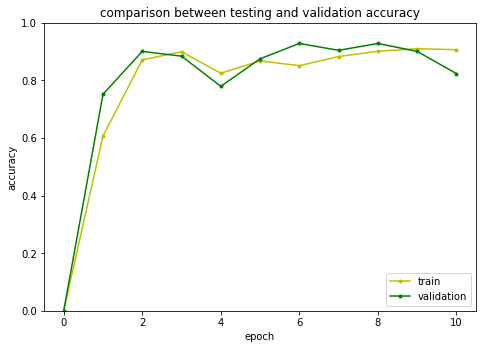

confunsion matrix is 
 396 1 5 
 37 306 17 
 151 2 251 
precision is 
class0:67.81 % 
class1:99.03 % 
class2:91.94 % 

recall is 
class0:98.51 % 
class1:85.00 % 
class2:62.13 % 

f1 is 
class0:80.32 % 
class1:91.48 % 
class2:74.15 % 

accuracy is 
class0:0.82


In [ ]:
plotvalidationandTraining(10,history_training_accuracy,history_validation_accuracy)
history_validation_accuracy.pop(0)
history_training_accuracy.pop(0)
report_yourmoder(few_layer_model,testX,testY)

In [ ]:
del opx
del few_layer_model
print("done")

done


# ***Pre-Trained Models***

## ***VGG 16***

### **Unweigted**

In [ ]:
base_model = VGG16(input_shape = (256, 256, 3), include_top = False, weights =None)

def pre_trained_modelVGG(premodel) :
  
  x = layers.Flatten()(premodel.output)

  # Add a fully connected layer with 512 hidden units and ReLU activation
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.5)(x)

  # Add a final sigmoid layer for classification
  x = layers.Dense(3, activation='softmax')(x)

  return  tf.keras.models.Model(premodel.input, x)   

In [ ]:
VGG16opt = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR)
vgg_model=pre_trained_modelVGG(base_model)
vgg_model.compile(optimizer=VGG16opt, loss=categorical_crossentropy, metrics=["acc"])

In [ ]:
history_validation_accuracy,history_training_accuracy=trainingloop(vgg_model,trainX,trainY,BS,10,VGG16opt)

[INFO] starting epoch 1/10...Epoch 000: Loss: 1.508, accuracy 0.38878676470588236
validation accuracy is 0.5110

took 0.7717 minutes
[INFO] starting epoch 2/10...Epoch 001: Loss: 0.845, accuracy 0.6360294117647058
validation accuracy is 0.6765

took 0.5887 minutes
[INFO] starting epoch 3/10...Epoch 002: Loss: 0.547, accuracy 0.7830882352941176
validation accuracy is 0.7794

took 0.5889 minutes
[INFO] starting epoch 4/10...Epoch 003: Loss: 0.377, accuracy 0.8782169117647058
validation accuracy is 0.9118

took 0.5876 minutes
[INFO] starting epoch 5/10...Epoch 004: Loss: 0.262, accuracy 0.9186580882352942
validation accuracy is 0.9154

took 0.5876 minutes
[INFO] starting epoch 6/10...Epoch 005: Loss: 0.289, accuracy 0.9122242647058824
validation accuracy is 0.9228

took 0.5869 minutes
[INFO] starting epoch 7/10...Epoch 006: Loss: 0.197, accuracy 0.9407169117647058
validation accuracy is 0.9430

took 0.5872 minutes
[INFO] starting epoch 8/10...Epoch 007: Loss: 0.143, accuracy 0.95680147058

#### **Test Accuracy**

37/37 [==============================] - 3s 77ms/step - loss: 0.2316 - acc: 0.9238
[INFO] test accuracy: 0.9245
confunsion matrix is 
 395 2 5 
 16 326 18 
 43 4 357 
precision is 
class0:87.00 % 
class1:98.19 % 
class2:93.95 % 

recall is 
class0:98.26 % 
class1:90.56 % 
class2:88.37 % 

f1 is 
class0:92.29 % 
class1:94.22 % 
class2:91.07 % 

accuracy is 
class0:0.92


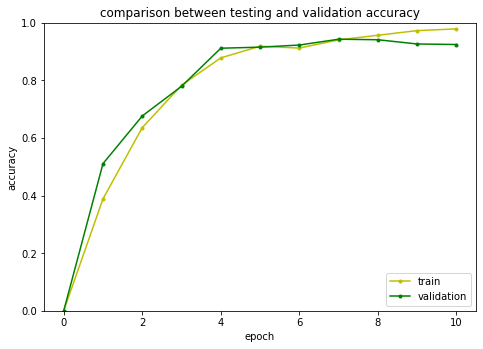

In [ ]:
testing(vgg_model,testX,testY)
report_yourmoder(vgg_model,testX,testY) 
plotvalidationandTraining(10,history_training_accuracy,history_validation_accuracy)
history_validation_accuracy.pop(0)
history_training_accuracy.pop(0)
del VGG16opt
del vgg_model
del base_model 

### **Weighted (Freezing Ealier Layers)** 

In [ ]:
base_model = VGG16(input_shape = (256, 256, 3), include_top = False, weights ="imagenet")

def pre_trained_modelVGG(premodel) :
  
  x = layers.Flatten()(premodel.output)
  for layer in premodel.layers:
      layer.trainable = False

  # Add a fully connected layer with 512 hidden units and ReLU activation
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.5)(x)

  # Add a final sigmoid layer for classification
  x = layers.Dense(3, activation='softmax')(x)

  return  tf.keras.models.Model(premodel.input, x)  

In [ ]:
VGG16opt = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR)
vgg_model=pre_trained_modelVGG(base_model)
vgg_model.compile(optimizer=VGG16opt, loss=categorical_crossentropy, metrics=["acc"])
history_validation_accuracy,history_training_accuracy=trainingloop(vgg_model,trainX,trainY,BS,10,VGG16opt)

[INFO] starting epoch 1/10...Epoch 000: Loss: 2.700, accuracy 0.8033088235294118
validation accuracy is 0.9320

took 0.6047 minutes
[INFO] starting epoch 2/10...Epoch 001: Loss: 0.130, accuracy 0.9646139705882353
validation accuracy is 0.9173

took 0.6039 minutes
[INFO] starting epoch 3/10...Epoch 002: Loss: 0.071, accuracy 0.9802389705882353
validation accuracy is 0.9559

took 0.6038 minutes
[INFO] starting epoch 4/10...Epoch 003: Loss: 0.045, accuracy 0.9889705882352942
validation accuracy is 0.9614

took 0.6021 minutes
[INFO] starting epoch 5/10...Epoch 004: Loss: 0.023, accuracy 0.9940257352941176
validation accuracy is 0.9761

took 0.6086 minutes
[INFO] starting epoch 6/10...Epoch 005: Loss: 0.015, accuracy 0.9986213235294118
validation accuracy is 0.9706

took 0.6015 minutes
[INFO] starting epoch 7/10...Epoch 006: Loss: 0.013, accuracy 0.9990808823529411
validation accuracy is 0.9596

took 0.6106 minutes
[INFO] starting epoch 8/10...Epoch 007: Loss: 0.012, accuracy 1.0
validation

#### **Test Accuracy**

37/37 [==============================] - 3s 77ms/step - loss: 0.2088 - acc: 0.9506
[INFO] test accuracy: 0.9451
confunsion matrix is 
 401 0 1 
 3 356 1 
 51 8 345 
precision is 
class0:88.13 % 
class1:97.80 % 
class2:99.42 % 

recall is 
class0:99.75 % 
class1:98.89 % 
class2:85.40 % 

f1 is 
class0:93.58 % 
class1:98.34 % 
class2:91.88 % 

accuracy is 
class0:0.95


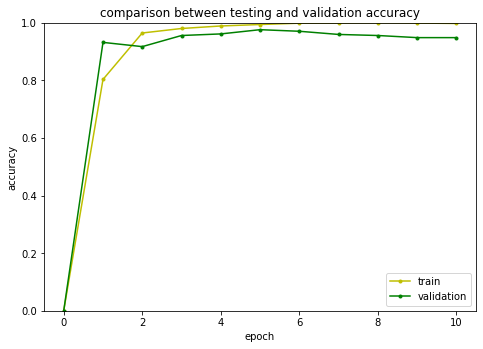

In [ ]:
testing(vgg_model,testX,testY)
report_yourmoder(vgg_model,testX,testY) 
plotvalidationandTraining(10,history_training_accuracy,history_validation_accuracy)
history_validation_accuracy.pop(0)
history_training_accuracy.pop(0)
del VGG16opt
del vgg_model
del base_model 

### **Weighted  All Layers  Is Traniable**

In [ ]:
base_model = VGG16(input_shape = (256, 256, 3), include_top = False, weights ="imagenet")

def pre_trained_modelVGG(premodel) :
  
  x = layers.Flatten()(premodel.output)
  for layer in premodel.layers:
      layer.trainable = True 

  # Add a fully connected layer with 512 hidden units and ReLU activation
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.5)(x)

  # Add a final sigmoid layer for classification
  x = layers.Dense(3, activation='softmax')(x)

  return  tf.keras.models.Model(premodel.input, x)  

#### **Test Accuracy** 

In [ ]:
VGG16opt = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR)
vgg_model=pre_trained_modelVGG(base_model)
vgg_model.compile(optimizer=VGG16opt, loss=categorical_crossentropy, metrics=["acc"])
history_validation_accuracy,history_training_accuracy=trainingloop(vgg_model,trainX,trainY,BS,10,VGG16opt)

[INFO] starting epoch 1/10...Epoch 000: Loss: 3.915, accuracy 0.3795955882352941
validation accuracy is 0.3548

took 0.6023 minutes
[INFO] starting epoch 2/10...Epoch 001: Loss: 0.794, accuracy 0.6493566176470589
validation accuracy is 0.8842

took 0.5992 minutes
[INFO] starting epoch 3/10...Epoch 002: Loss: 0.378, accuracy 0.8717830882352942
validation accuracy is 0.8327

took 0.5969 minutes
[INFO] starting epoch 4/10...Epoch 003: Loss: 0.384, accuracy 0.8818933823529411
validation accuracy is 0.9081

took 0.5969 minutes
[INFO] starting epoch 5/10...Epoch 004: Loss: 0.202, accuracy 0.9319852941176471
validation accuracy is 0.9007

took 0.5965 minutes
[INFO] starting epoch 6/10...Epoch 005: Loss: 0.276, accuracy 0.9163602941176471
validation accuracy is 0.8971

took 0.5975 minutes
[INFO] starting epoch 7/10...Epoch 006: Loss: 0.163, accuracy 0.9457720588235294
validation accuracy is 0.9191

took 0.5966 minutes
[INFO] starting epoch 8/10...Epoch 007: Loss: 0.153, accuracy 0.946231617647

37/37 [==============================] - 3s 77ms/step - loss: 0.1652 - acc: 0.9505
[INFO] test accuracy: 0.9460
confunsion matrix is 
 388 2 12 
 4 338 18 
 22 5 377 
precision is 
class0:93.72 % 
class1:97.97 % 
class2:92.63 % 

recall is 
class0:96.52 % 
class1:93.89 % 
class2:93.32 % 

f1 is 
class0:95.10 % 
class1:95.89 % 
class2:92.97 % 

accuracy is 
class0:0.95


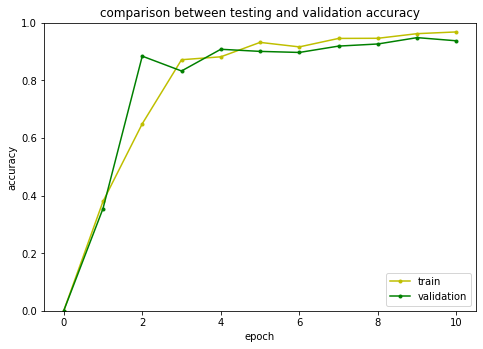

In [ ]:
testing(vgg_model,testX,testY)
report_yourmoder(vgg_model,testX,testY) 
plotvalidationandTraining(10,history_training_accuracy,history_validation_accuracy)
history_validation_accuracy.pop(0)
history_training_accuracy.pop(0)
del VGG16opt
del vgg_model
del base_model 

## **ResNet 50**

In [ ]:
del reznet50model

### **Unweigted**

In [ ]:
base_model = ResNet50(input_shape = (256, 256, 3), include_top = False, weights = None)

def pre_trained_modelReznet(premodel) :
  for layer in base_model.layers:
      layer.trainable = True
  x = layers.Flatten()(base_model.output)

  # Add a fully connected layer with 512 hidden units and ReLU activation
  x = layers.Dense(64, activation='relu')(x)

  # # Add a dropout rate of 0.5
  # x = layers.Dropout(0.5)(x)

  # Add a final sigmoid layer for classification
  x = layers.Dense(3, activation='softmax')(x)

  return  tf.keras.models.Model(base_model.input, x)   

In [ ]:
del base_model

In [ ]:
reznet50opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)#2#3#4
reznet50model=pre_trained_modelReznet(base_model)
reznet50model.compile(optimizer=reznet50opt, loss=categorical_crossentropy, metrics=["acc"])
history_validation_accuracy,history_training_accuracy=trainingloop(reznet50model,trainX,trainY,BS,20,reznet50opt)

[INFO] starting epoch 1/20...Epoch 000: Loss: 427.111, accuracy 0.5298713235294118
validation accuracy is 0.6912

took 0.4119 minutes
[INFO] starting epoch 2/20...Epoch 001: Loss: 0.476, accuracy 0.8023897058823529
validation accuracy is 0.8768

took 0.3896 minutes
[INFO] starting epoch 3/20...Epoch 002: Loss: 0.328, accuracy 0.8782169117647058
validation accuracy is 0.9136

took 0.3882 minutes
[INFO] starting epoch 4/20...Epoch 003: Loss: 0.253, accuracy 0.9140625
validation accuracy is 0.9265

took 0.3891 minutes
[INFO] starting epoch 5/20...Epoch 004: Loss: 0.213, accuracy 0.9306066176470589
validation accuracy is 0.9099

took 0.3885 minutes
[INFO] starting epoch 6/20...Epoch 005: Loss: 0.235, accuracy 0.9200367647058824
validation accuracy is 0.9007

took 0.3892 minutes
[INFO] starting epoch 7/20...Epoch 006: Loss: 0.188, accuracy 0.9402573529411765
validation accuracy is 0.9191

took 0.3877 minutes
[INFO] starting epoch 8/20...Epoch 007: Loss: 0.166, accuracy 0.9471507352941176
va

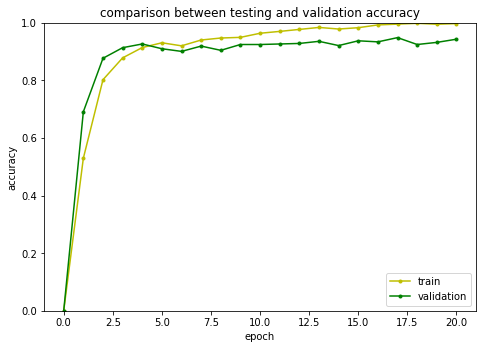

0

In [ ]:
plotvalidationandTraining(20,history_training_accuracy,history_validation_accuracy)
history_validation_accuracy.pop(0)
history_training_accuracy.pop(0)

#### **Test Accuracy**

In [ ]:
testing(reznet50model,testX,testY)
report_yourmoder(reznet50model,testX,testY) 

del reznet50opt
del reznet50model
del base_model 

37/37 [==============================] - 4s 65ms/step - loss: 0.2559 - acc: 0.9518
[INFO] test accuracy: 0.9408
confunsion matrix is 
 368 2 32 
 2 346 12 
 17 4 383 
precision is 
class0:95.09 % 
class1:98.30 % 
class2:89.70 % 

recall is 
class0:91.54 % 
class1:96.11 % 
class2:94.80 % 

f1 is 
class0:93.28 % 
class1:97.19 % 
class2:92.18 % 

accuracy is 
class0:0.94


### **Wighted Layers**

In [ ]:
base_model = ResNet50(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet')

def pre_trained_modelReznet(premodel) :
  for layer in base_model.layers:
      layer.trainable = False
  x = layers.Flatten()(base_model.output)

  # Add a fully connected layer with 512 hidden units and ReLU activation
  x = layers.Dense(64, activation='relu')(x)

  # # Add a dropout rate of 0.5
  # x = layers.Dropout(0.5)(x)

  # Add a final sigmoid layer for classification
  x = layers.Dense(3, activation='softmax')(x)

  return  tf.keras.models.Model(base_model.input, x)   

[0,
 0.6911764705882353,
 0.8768382352941176,
 0.9136029411764706,
 0.9264705882352942,
 0.9099264705882353,
 0.9007352941176471,
 0.9191176470588235,
 0.9044117647058824,
 0.9246323529411765,
 0.9246323529411765,
 0.9264705882352942,
 0.9283088235294118,
 0.9356617647058824,
 0.9209558823529411,
 0.9375,
 0.9338235294117647,
 0.9485294117647058,
 0.9246323529411765,
 0.9319852941176471,
 0.9430147058823529]

In [ ]:
reznet50opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)#2#3#4
reznet50model=pre_trained_modelReznet(base_model)
reznet50model.compile(optimizer=reznet50opt, loss=categorical_crossentropy, metrics=["acc"])

In [ ]:
history_validation_accuracy,history_training_accuracy=trainingloop(reznet50model,trainX,trainY,64,8,reznet50opt)

[INFO] starting epoch 1/8...Epoch 000: Loss: 4.849, accuracy 0.9007352941176471
validation accuracy is 0.9099

took 0.4076 minutes
[INFO] starting epoch 2/8...Epoch 001: Loss: 0.258, accuracy 0.9802389705882353
validation accuracy is 0.9504

took 0.3855 minutes
[INFO] starting epoch 3/8...Epoch 002: Loss: 0.105, accuracy 0.9912683823529411
validation accuracy is 0.9577

took 0.3859 minutes
[INFO] starting epoch 4/8...Epoch 003: Loss: 0.029, accuracy 0.9963235294117647
validation accuracy is 0.9504

took 0.3858 minutes
[INFO] starting epoch 5/8...Epoch 004: Loss: 0.005, accuracy 0.9986213235294118
validation accuracy is 0.9596

took 0.3856 minutes
[INFO] starting epoch 6/8...Epoch 005: Loss: 0.003, accuracy 0.9990808823529411
validation accuracy is 0.9577

took 0.3852 minutes
[INFO] starting epoch 7/8...Epoch 006: Loss: 0.002, accuracy 0.9990808823529411
validation accuracy is 0.9614

took 0.3856 minutes
[INFO] starting epoch 8/8...Epoch 007: Loss: 0.001, accuracy 0.9990808823529411
val

first 20 epoch

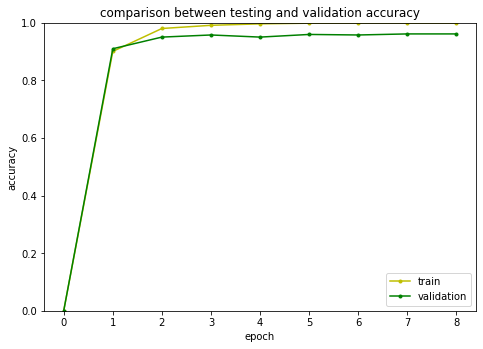

0

In [ ]:
plotvalidationandTraining(8,history_training_accuracy,history_validation_accuracy)
history_validation_accuracy.pop(0)
history_training_accuracy.pop(0)

#### **Test Accuracy**

In [ ]:
testing(reznet50model,testX,testY)
report_yourmoder(reznet50model,testX,testY) 
del reznet50opt
del reznet50model

37/37 [==============================] - 4s 65ms/step - loss: 0.2736 - acc: 0.9730
[INFO] test accuracy: 0.9734
confunsion matrix is 
 386 1 15 
 2 354 4 
 7 2 395 
precision is 
class0:97.72 % 
class1:99.16 % 
class2:95.41 % 

recall is 
class0:96.02 % 
class1:98.33 % 
class2:97.77 % 

f1 is 
class0:96.86 % 
class1:98.74 % 
class2:96.58 % 

accuracy is 
class0:0.97


## **Inception V3**

#### **Freezing**

In [ ]:
base_model = InceptionV3(input_shape = (256, 256, 3), include_top = False, # Leave out the last fully connected layer
weights = "imagenet")

def pre_trained_modelinception(premodel) :

  for layer in premodel.layers[:200]:
        layer.trainable = False
  for layer in premodel.layers[200:]:
        layer.trainable = True
  x = layers.Flatten()(base_model.output)

  # Add a fully connected layer with 512 hidden units and ReLU activation
  x = layers.Dense(128, activation='relu')(x)

  # Add a dropout rate of 0.5
  x = layers.Dropout(0.5)(x)
  # x = BatchNormalization()(x)
  # Add a final sigmoid layer for classification
  x = layers.Dense(3, activation='softmax')(x)

  return  tf.keras.models.Model(base_model.input, x) 

In [ ]:
inceptionopt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)#2#3#4

inceptionX=pre_trained_modelinception(base_model)
inceptionX.compile(optimizer=inceptionopt , loss=categorical_crossentropy,
              metrics=["acc"])

In [ ]:
history_validation_accuracy,history_training_accuracy=trainingloop(inceptionX,trainX,trainY,BS,10,inceptionopt)

[INFO] starting epoch 1/10...Epoch 000: Loss: 1.791, accuracy 0.5667842741935484
validation accuracy is 0.8413

took 0.6908 minutes
[INFO] starting epoch 2/10...Epoch 001: Loss: 0.269, accuracy 0.9133064516129032
validation accuracy is 0.9692

took 0.6608 minutes
[INFO] starting epoch 3/10...Epoch 002: Loss: 0.204, accuracy 0.9417842741935484
validation accuracy is 0.9286

took 0.6612 minutes
[INFO] starting epoch 4/10...Epoch 003: Loss: 0.163, accuracy 0.9564012096774194
validation accuracy is 0.9643

took 0.6591 minutes
[INFO] starting epoch 5/10...Epoch 004: Loss: 0.112, accuracy 0.9717741935483871
validation accuracy is 0.9643

took 0.6556 minutes
[INFO] starting epoch 6/10...Epoch 005: Loss: 0.071, accuracy 0.9838709677419355
validation accuracy is 0.9732

took 0.6553 minutes
[INFO] starting epoch 7/10...Epoch 006: Loss: 0.062, accuracy 0.9873991935483871
validation accuracy is 0.9692

took 0.6619 minutes
[INFO] starting epoch 8/10...Epoch 007: Loss: 0.062, accuracy 0.988407258064

#### **Test Accuracy**

In [ ]:
history_validation_accuracy.pop(0)
history_training_accuracy.pop(0)

0

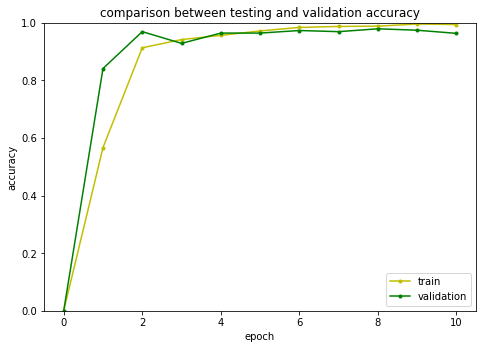

68/68 [==============================] - 6s 60ms/step - loss: 0.1634 - acc: 0.9640
[INFO] test accuracy: 0.9606
confunsion matrix is 
 659 4 57 
 3 710 7 
 13 1 706 
precision is 
class0:97.63 % 
class1:99.30 % 
class2:91.69 % 

recall is 
class0:91.53 % 
class1:98.61 % 
class2:98.06 % 

f1 is 
class0:94.48 % 
class1:98.95 % 
class2:94.77 % 

accuracy is 
class0:0.96


In [ ]:
plotvalidationandTraining(10,history_training_accuracy,history_validation_accuracy)
history_validation_accuracy.pop(0)
history_training_accuracy.pop(0)
testing(inceptionX,testX,testY)
report_yourmoder(inceptionX,testX,testY) 
del inceptionopt
del inceptionX
del base_model 